# Data loading and preprocessing

In [1]:
import pandas as pd  
from IPython.display import display
import numpy as np

In [2]:
data=pd.read_csv('insurance.csv')

In [3]:
print("NAN")
nan_counts = data.isna().sum()
print(nan_counts[nan_counts > 0])

print("\nNULL")
null_counts = data.isnull().sum()
print(null_counts[null_counts > 0])

NAN
Series([], dtype: int64)

NULL
Series([], dtype: int64)


In [4]:
data.duplicated().sum()

np.int64(1)

In [5]:
data.drop_duplicates(inplace=True)

In [6]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
for col in data.select_dtypes(include='object').columns:
    data[col]=encoder.fit_transform(data[col])

In [7]:
data.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [8]:
important_features = data[['sex', 'children', 'smoker', 'region']]
for col in important_features.columns:
    print(data[col].value_counts())

sex
1    675
0    662
Name: count, dtype: int64
children
0    573
1    324
2    240
3    157
4     25
5     18
Name: count, dtype: int64
smoker
0    1063
1     274
Name: count, dtype: int64
region
2    364
3    325
1    324
0    324
Name: count, dtype: int64


In [9]:
def remove_outliers_iqr(df, exclude_columns=None, factor=1.5):

    df_clean = df.copy()
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    if exclude_columns is not None:
        columns_to_check = [col for col in numeric_columns if col not in exclude_columns]
    else:
        columns_to_check = numeric_columns
    
    print("Original shape:", df.shape)
    indices_to_remove = set()
    
    for col in columns_to_check:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
    
        outlier_indices = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        indices_to_remove.update(outlier_indices)
    
        print(f"Column {col}: {len(outlier_indices)} outliers detected")
    df_clean = df_clean.drop(list(indices_to_remove))
    
    print("Shape after outlier removal:", df_clean.shape)
    print(f"Total rows removed: {len(indices_to_remove)}")
    return df_clean
exclude_cols = ['sex', 'children', 'smoker', 'region']
data_cleaned = remove_outliers_iqr(data, exclude_columns=exclude_cols)

Original shape: (1337, 7)
Column age: 0 outliers detected
Column bmi: 9 outliers detected
Column charges: 139 outliers detected
Shape after outlier removal: (1192, 7)
Total rows removed: 145


In [10]:
x = data_cleaned.iloc[:, :-1]
y = data_cleaned.iloc[:, -1]

# Regression

## Error and data split

In [11]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def error (y_test, y_pred):
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R-squared: {r2:.4f}")
    
    # Create residual plot
    residuals = y_test - y_pred
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title('Residual Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()
    
    return mse, rmse, r2

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [13]:

from sklearn.preprocessing import StandardScaler
numeric_cols = X_train.select_dtypes(include=np.number).columns

scaler = StandardScaler()
X_train_scaled_numeric = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled_numeric = scaler.transform(X_test[numeric_cols])
X_train_scaled = pd.DataFrame(X_train_scaled_numeric, columns=numeric_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled_numeric, columns=numeric_cols, index=X_test.index)

In [14]:
X_train=X_train_scaled
X_test=X_test_scaled

## Model

Linear:
- finds a linear relationship 

MSE: 25164093.07
RMSE: 5016.38
R-squared: 0.5403


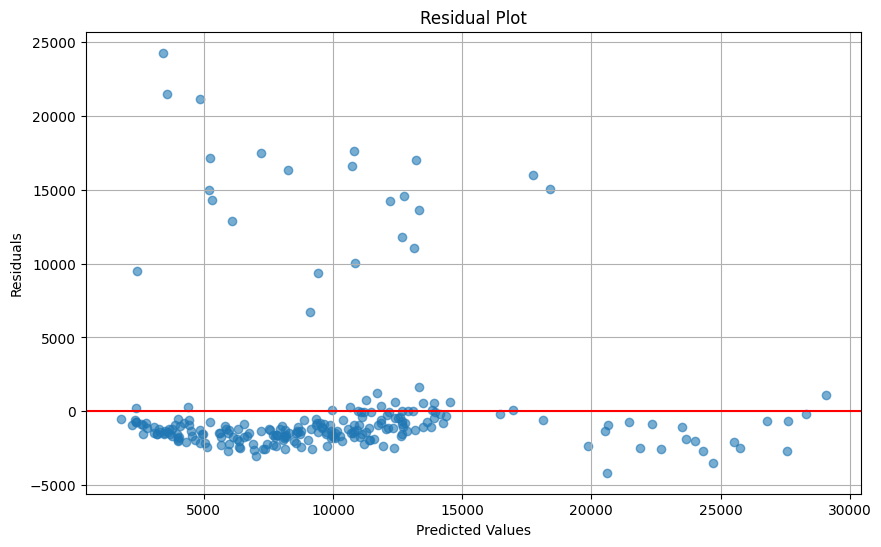

(25164093.072186545, np.float64(5016.382468690615), 0.5402699677447209)

In [15]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)

error(y_test,y_pred)

Ridge:
- uses L2
- min value of square of theta
- shrinks to near 0 

MSE: 25162458.97
RMSE: 5016.22
R-squared: 0.5403


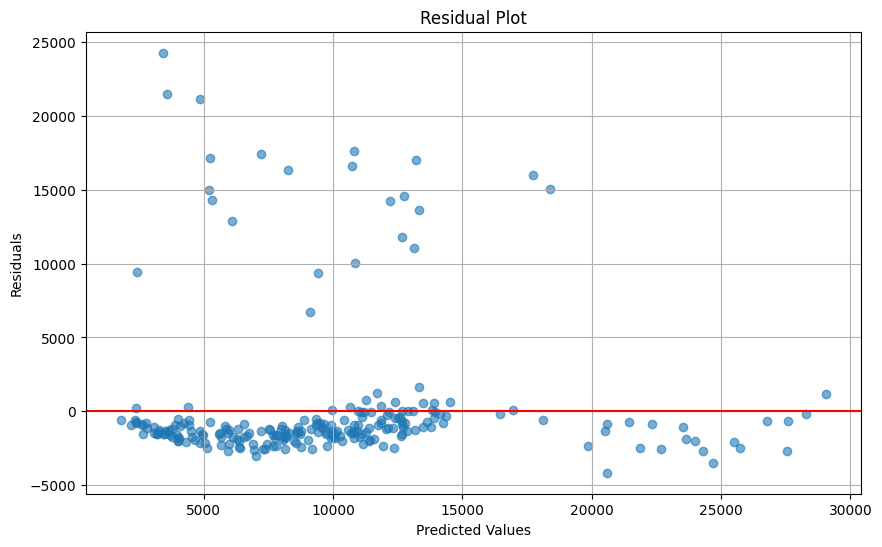

(25162458.97004619, np.float64(5016.219589496276), 0.5402998216253094)

In [16]:
from sklearn.linear_model import Ridge

ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)
error(y_test,y_pred)

Lasso:
- uses L1
- min value of abs of theta
- removes features by making it actually 0

MSE: 25163012.27
RMSE: 5016.27
R-squared: 0.5403


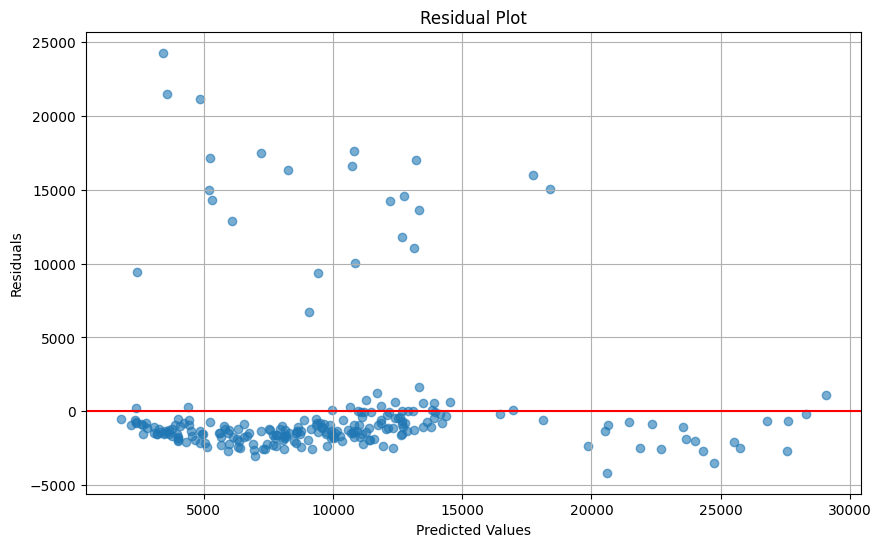

(25163012.266164035, np.float64(5016.27473990052), 0.5402897132998723)

In [17]:
from sklearn.linear_model import Lasso

lasso_model = Lasso()
lasso_model.fit(X_train, y_train)

y_pred = lasso_model.predict(X_test)
error(y_test,y_pred)

ElasticNet:
- uses both lasso(l1) and ridge(l2)
- if both == 0, we use mse 
- if l1>0, l2=0, we use lasso 
- if l1=0, l2>0, we use ridge
- if both>0 , we use hybrid of two 

MSE: 28503955.86
RMSE: 5338.91
R-squared: 0.4793


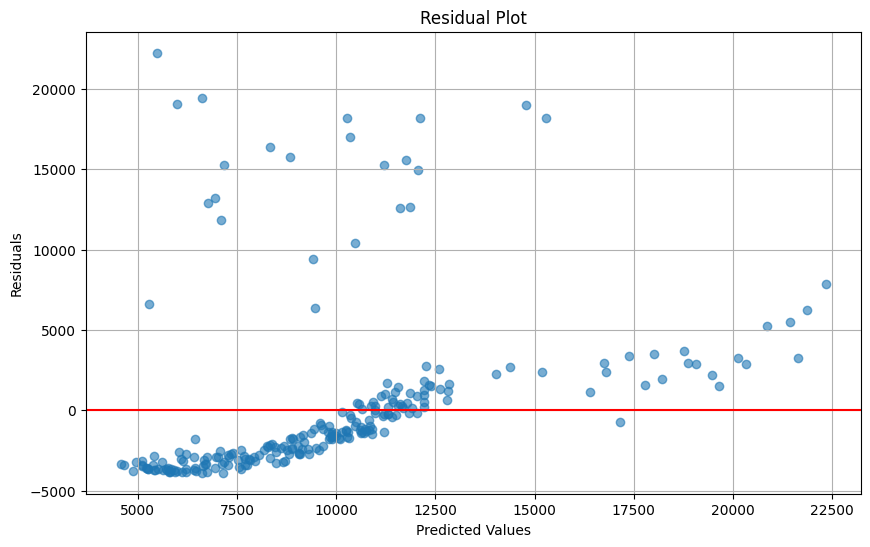

(28503955.858961556, np.float64(5338.909613297603), 0.4792530567721027)

In [18]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet()
elastic_net.fit(X_train, y_train)
y_pred = elastic_net.predict(X_test)
error(y_test,y_pred)

Decision Tree Regessor:
- uses nodes to split data
- although data is continios , there will be some clusters vissible 
- uses variance as an impurity matrix to choose the best nodes

MSE: 22945463.33
RMSE: 4790.14
R-squared: 0.5808


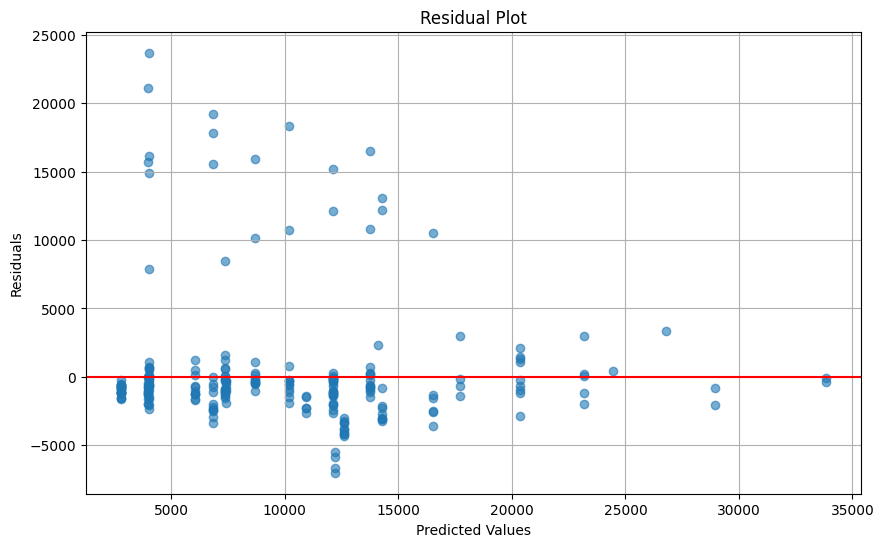

(22945463.330744285, np.float64(4790.142307984626), 0.5808027506934188)

In [19]:
from sklearn.tree import DecisionTreeRegressor
dt_regressor = DecisionTreeRegressor(max_depth=5)
dt_regressor.fit(X_train, y_train)
y_pred = dt_regressor.predict(X_test)
error(y_test,y_pred)

Random Forest Regressor:
- make n number of trees
- pass the new data points through the trees
- take the avg of all the optputs of the trees
- compare with the actual value

MSE: 25433707.14
RMSE: 5043.18
R-squared: 0.5353


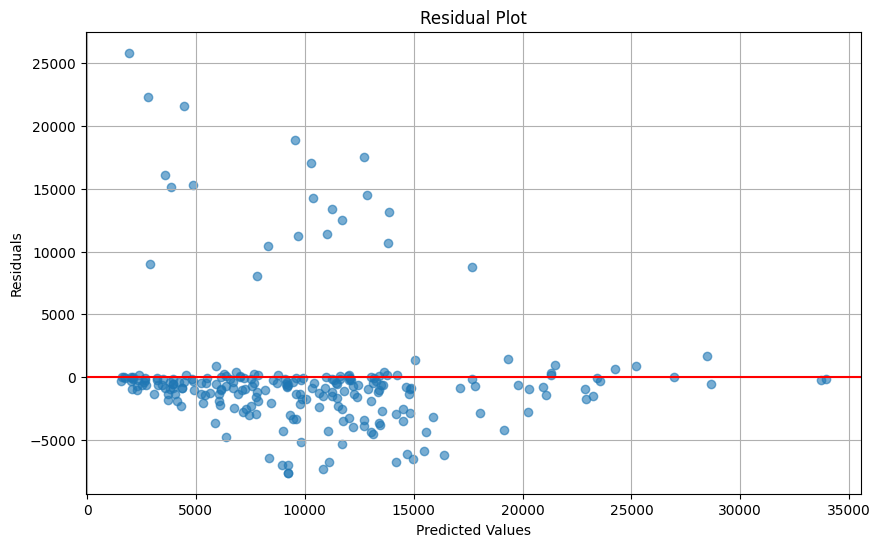

(25433707.13903158, np.float64(5043.184226164218), 0.5353443110444543)

In [20]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)
error(y_test,y_pred)

Gradiet Boost:
- first predicts the avg
- then checks for error, classfies it as psudo error
- makes tree to find that psudo error
- takes many steps (0.1) to find the actual values

MSE: 23528876.89
RMSE: 4850.66
R-squared: 0.5701


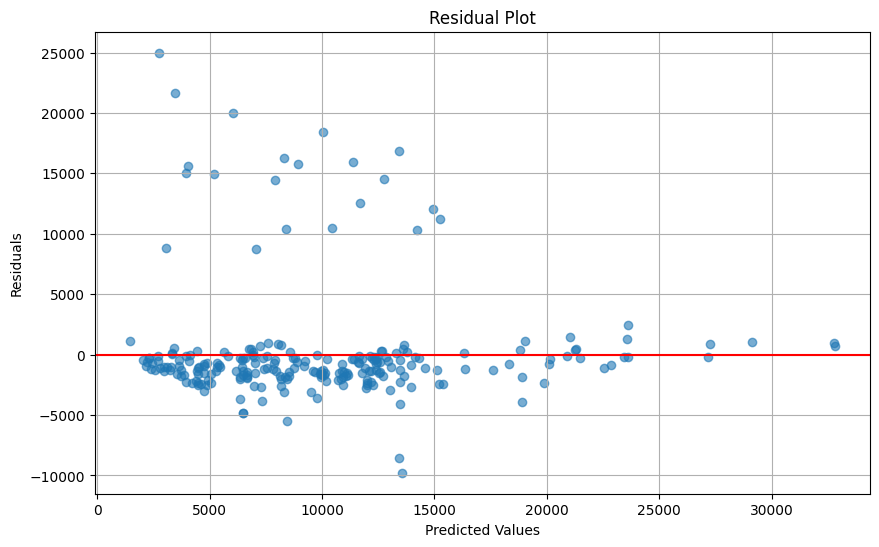

(23528876.890522994, np.float64(4850.657366844518), 0.5701442010732982)

In [21]:
from sklearn.ensemble import GradientBoostingRegressor
gb_regressor = GradientBoostingRegressor()
gb_regressor.fit(X_train, y_train)
y_pred = gb_regressor.predict(X_test)

error(y_test,y_pred)

XGBoost:
- better gradient boost as it has regularization built in
- uses pruning of trees 
- has built in cross validation and null value handling 

MSE: 22386290.61
RMSE: 4731.42
R-squared: 0.5910


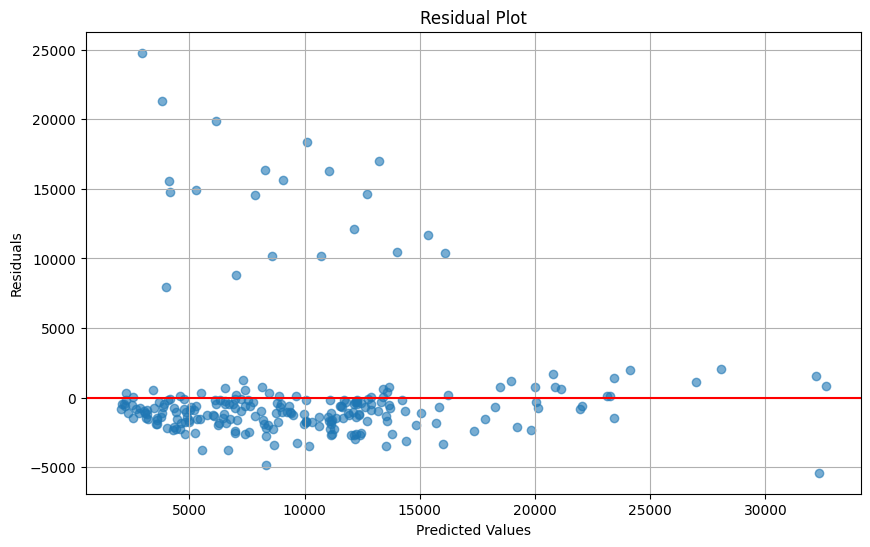

(22386290.608723413, np.float64(4731.415286013627), 0.5910184374973697)

In [22]:
import xgboost as xgb
xgb_regressor = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3,reg_alpha=0.1,reg_lambda=1.0)
xgb_regressor.fit(X_train, y_train)
y_pred = xgb_regressor.predict(X_test)
error(y_test,y_pred)

MSE: 57946209.05
RMSE: 7612.24
R-squared: -0.0586


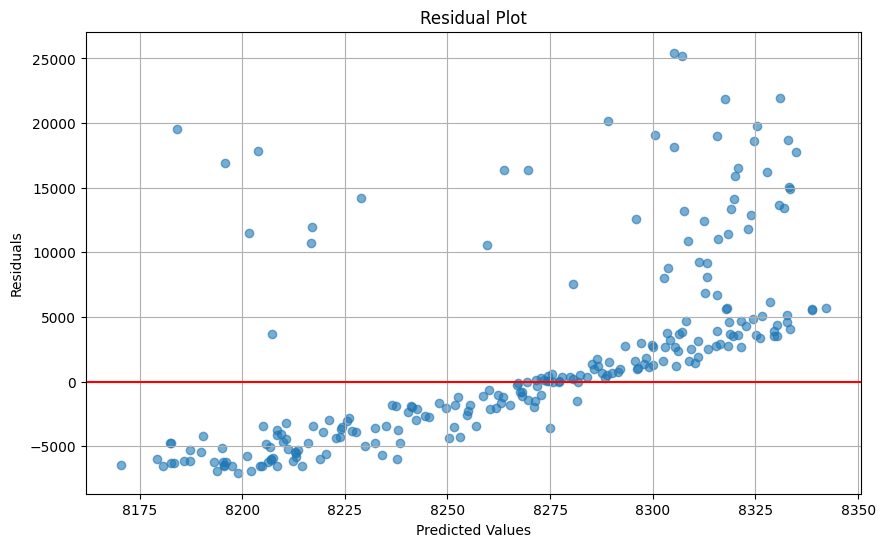

(57946209.047862604, np.float64(7612.240737645034), -0.058635909437536826)

In [23]:
from sklearn.svm import SVR
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train, y_train)
y_pred = svr_model.predict(X_test)
error(y_test,y_pred)

MSE: 57946209.05
RMSE: 7612.24
R-squared: -0.0586


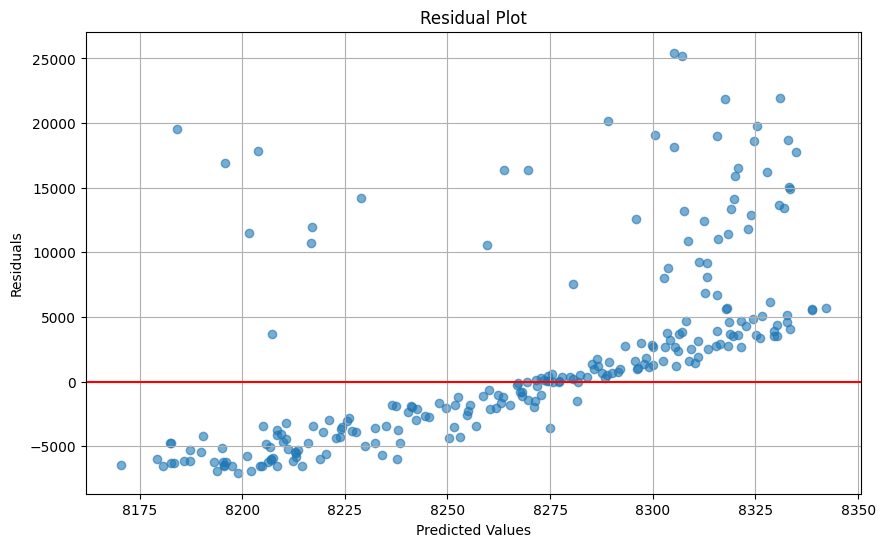

(57946209.047862604, np.float64(7612.240737645034), -0.058635909437536826)

In [ ]:
from sklearn.svm import SVR

svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train, y_train)

y_pred = svr_model.predict(X_test)
error(y_test,y_pred)